In [ ]:
import pandas as pd
import pvlib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import numpy as np

In [4]:
def load_pv_generation(file_path):
    pv_generation = pd.read_csv(
    file_path,
    usecols=["Time to [CET/CEST]", "Solar [MW]"],
    parse_dates=["Time to [CET/CEST]"],
    index_col = "Time to [CET/CEST]")

    # End of Daylight Saving Time (DST). We merge the two as this happen during the night, so solar production is 0.
    pv_generation.index = pv_generation.index.str.replace("2A:", "02:", regex=False)
    pv_generation.index = pv_generation.index.str.replace("2B:", "02:", regex=False)

    pv_generation.index = pd.to_datetime(pv_generation.index)

    return pv_generation.resample("h", closed="right", label="right").sum()

In [5]:
pv_generation_2020 = load_pv_generation("./data/Erzeugung nach Typ_M15_2020_English.csv")
pv_generation_2021 = load_pv_generation("./data/Erzeugung nach Typ_M15_2021_English.csv")
pv_generation_2022 = load_pv_generation("./data/Erzeugung nach Typ_M15_2022_English.csv")
pv_generation = pd.concat([pv_generation_2020, pv_generation_2021, pv_generation_2022]).rename_axis("Time").rename(columns={"Solar [MW]": "pv_gen"})

# Check if no overlap
print(pv_generation.index.is_unique)

pv_generation.head()

True


,pv_gen
Time,
2020-01-01 01:00:00,0.0
2020-01-01 02:00:00,0.0
2020-01-01 03:00:00,0.0
2020-01-01 04:00:00,0.0
2020-01-01 05:00:00,0.0


In [14]:
weather_points = pd.read_csv("./data/open_meteo.zip", nrows=50)
weather_points.info


forecast = (pd.read_csv(
    "./data/open_meteo.csv", 
    skiprows=51,
    parse_dates=["time"])
    .rename(columns={"temperature_2m (°C)": "tt", "wind_speed_10m (km/h)": "wind", "shortwave_radiation (W/m²)": "rad"})
)

#Flatten the forecast to have all the weather points on same column.
forecast = forecast.pivot(index="time", columns="location_id", values=["tt", "wind", "rad"])
forecast.columns = [f"{var}_{loc_id}" for var, loc_id in forecast.columns]


forecast.head()

,tt_0,tt_1,tt_2,tt_3,tt_4,tt_5,tt_6,tt_7,tt_8,tt_9,...,rad_40,rad_41,rad_42,rad_43,rad_44,rad_45,rad_46,rad_47,rad_48,rad_49
time,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,-4.4,-1.4,-0.9,-4.0,1.0,-3.8,-5.7,-3.0,-11.5,-4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 01:00:00,-6.9,-1.5,-1.0,-3.5,-0.4,-3.5,-8.6,-1.2,-12.4,-3.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 02:00:00,-3.8,-1.6,-1.3,-3.7,-1.0,-3.6,-6.6,-1.4,-13.0,-3.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 03:00:00,-2.6,-1.6,-2.3,-4.2,-1.5,-3.6,-7.2,-2.9,-12.2,-3.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 04:00:00,-2.2,-1.7,-4.9,-4.1,-1.6,-3.7,-8.9,-3.2,-12.4,-7.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
dataset = pd.concat([pv_generation, forecast], axis=1, join="inner")

weather_cols = [c for c in dataset.columns if c.startswith(("rad_", "tt_", "wind_"))]

dataset[weather_cols] = dataset[weather_cols].shift(-2) #create +2hours prediction
dataset["pv_gen_+2h"] = dataset["pv_gen"].shift(-2)
dataset["day_of_year"] = dataset.index.day_of_year
dataset["hour"] = dataset.index.hour

dataset = dataset.dropna()
dataset.info

/tmp/ipykernel_24515/99316382.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset["pv_gen_+2h"] = dataset["pv_gen"].shift(-2)
/tmp/ipykernel_24515/99316382.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset["day_of_year"] = dataset.index.day_of_year
/tmp/ipykernel_24515/99316382.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

<bound method DataFrame.info of                      pv_gen  tt_0  tt_1  tt_2  tt_3  tt_4  tt_5  tt_6  tt_7  \
2020-01-01 01:00:00     0.0  -2.6  -1.6  -2.3  -4.2  -1.5  -3.6  -7.2  -2.9   
2020-01-01 02:00:00     0.0  -2.2  -1.7  -4.9  -4.1  -1.6  -3.7  -8.9  -3.2   
2020-01-01 03:00:00     0.0  -2.1  -1.9  -4.4  -3.7  -1.0  -3.6  -8.6  -3.4   
2020-01-01 04:00:00     0.0  -2.0  -2.0  -5.4  -3.5  -1.4  -3.7  -7.2  -3.1   
2020-01-01 05:00:00     0.0  -2.4  -2.1  -6.3  -3.9  -1.7  -3.9  -4.8  -3.0   
...                     ...   ...   ...   ...   ...   ...   ...   ...   ...   
2022-12-31 18:00:00     0.0  -3.6  -0.8   1.2   3.9   6.0   1.2   2.0   2.2   
2022-12-31 19:00:00     0.0  -3.5  -1.2   0.7   3.7   5.5   1.1   1.6   1.8   
2022-12-31 20:00:00     0.0  -3.8  -1.2   0.3   3.7   4.8   1.1   1.8   1.2   
2022-12-31 21:00:00     0.0  -4.2  -1.1  -0.2   3.9   4.4   0.8   2.5   1.0   
2022-12-31 22:00:00     0.0  -2.6   3.7  -3.9   1.9   3.0   0.3   2.8   2.0   

                   

In [ ]:
def get_solar_position(timestamps, lat=47.5162, lon=14.5501):
    """
    Calculates Solar Elevation and Azimuth for Austria's centroid using pvlib.
    Input: Pandas DatetimeIndex (UTC)
    Output: DataFrame with 'solar_elev' and 'solar_azimuth'
    """
    # pvlib expects a DatetimeIndex localized to UTC (or timezone aware)
    # If your index is already UTC but naive, localize it just in case:
    if timestamps.tz is None:
        times = timestamps.tz_localize('UTC')
    else:
        times = timestamps

    # Calculate position
    solpos = pvlib.solarposition.get_solarposition(
        times,
        latitude=lat,
        longitude=lon,
        method='nrel_numpy'
    )

    return pd.DataFrame({
        'solar_elev': solpos['apparent_elevation'].values,
        'solar_azimuth': solpos['azimuth'].values
    }, index=timestamps)

solar_features = get_solar_position(dataset.index)
dataset['solar_elev'] = solar_features['solar_elev']
dataset['solar_azimuth'] = solar_features['solar_azimuth']

In [ ]:
def train_model(dataset, features, target, test_size_hours, n_estimator=1000, learning_rate=0.05, max_depth=6, early_stopping_rounds=50, n_jobs=-1, random_state=100):
    
    # Assuming target is a list like ['pv_gen']
    global_capacity = dataset[target].max().values[0]
    
    min_train_hours = 24*365 
    step_hours = 24*30 

    X = dataset[features]
    y = dataset[target]

    print(f"Total Data Points: {len(dataset)}")
    print(f"Capacity used for NRMSE: {global_capacity:.2f} MW")

    scores = []
    nrmse_list = []
    models = []

    
    print("Starting Time Series Cross-Validation...")

    for fold, i in enumerate(range(min_train_hours, len(dataset) - test_size_hours + 1, step_hours), 1):
        
        train_end_idx = i
        test_end_idx = i + test_size_hours
        
        X_train = X.iloc[:train_end_idx]
        y_train = y.iloc[:train_end_idx]
        
        X_test = X.iloc[train_end_idx:test_end_idx]
        y_test = y.iloc[train_end_idx:test_end_idx]

        model_cv = xgb.XGBRegressor(
            n_estimators=n_estimator,
            learning_rate=learning_rate,
            max_depth=max_depth,
            early_stopping_rounds=early_stopping_rounds,
            n_jobs=n_jobs,
            random_state=random_state
        )
        
        model_cv.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=False 
        )
        
        models.append(model_cv)
        preds = model_cv.predict(X_test)        
        preds = np.maximum(preds, 0)
        
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        
        nrmse = (rmse / global_capacity) * 100
        
        scores.append(rmse)
        nrmse_list.append(nrmse)

        print(f"Fold {fold}: RMSE = {rmse:.2f} MW, NRMSE = {nrmse:.2f}% (Train: {len(X_train)}, Test: {len(X_test)})")

    print("-" * 30)
    print(f"Average RMSE: {np.mean(scores):.2f} MW")
    print(f"Average NRMSE: {np.mean(nrmse_list):.2f}%")
    return models  
    

In [ ]:
features = ['pv_gen', "solar_elev", "solar_azimuth"]
target = ["pv_gen_+2h"]
test_size_hours = 31*24 

models = train_model(dataset, features, target, test_size_hours)

Total Data Points: 26302
Capacity used for NRMSE: 2944.00 MW
Starting Time Series Cross-Validation...
Fold 1: RMSE = 41.67 MW, NRMSE = 1.42% (Train: 8760, Test: 744)
Fold 2: RMSE = 87.88 MW, NRMSE = 2.99% (Train: 9480, Test: 744)
Fold 3: RMSE = 109.77 MW, NRMSE = 3.73% (Train: 10200, Test: 744)
Fold 4: RMSE = 120.33 MW, NRMSE = 4.09% (Train: 10920, Test: 744)
Fold 5: RMSE = 107.97 MW, NRMSE = 3.67% (Train: 11640, Test: 744)
Fold 6: RMSE = 67.93 MW, NRMSE = 2.31% (Train: 12360, Test: 744)
Fold 7: RMSE = 70.35 MW, NRMSE = 2.39% (Train: 13080, Test: 744)
Fold 8: RMSE = 82.52 MW, NRMSE = 2.80% (Train: 13800, Test: 744)
Fold 9: RMSE = 74.45 MW, NRMSE = 2.53% (Train: 14520, Test: 744)
Fold 10: RMSE = 69.77 MW, NRMSE = 2.37% (Train: 15240, Test: 744)
Fold 11: RMSE = 71.63 MW, NRMSE = 2.43% (Train: 15960, Test: 744)
Fold 12: RMSE = 43.82 MW, NRMSE = 1.49% (Train: 16680, Test: 744)
Fold 13: RMSE = 43.50 MW, NRMSE = 1.48% (Train: 17400, Test: 744)
Fold 14: RMSE = 72.61 MW, NRMSE = 2.47% (Train: 

In [ ]:
rad = [c for c in dataset.columns if c.startswith(("rad_"))]
features = ['day_of_year', 'pv_gen', "solar_elev", "solar_azimuth"] + rad
target = ["pv_gen_+2h"]
test_size_hours = 31*24


weather_models = train_model(dataset, features, target, test_size_hours)

Total Data Points: 26302
Capacity used for NRMSE: 2944.00 MW
Starting Time Series Cross-Validation...
Fold 1: RMSE = 56.06 MW, NRMSE = 1.90% (Train: 8760, Test: 744)
Fold 2: RMSE = 92.29 MW, NRMSE = 3.13% (Train: 9480, Test: 744)
Fold 3: RMSE = 97.28 MW, NRMSE = 3.30% (Train: 10200, Test: 744)
Fold 4: RMSE = 130.61 MW, NRMSE = 4.44% (Train: 10920, Test: 744)
Fold 5: RMSE = 91.86 MW, NRMSE = 3.12% (Train: 11640, Test: 744)
Fold 6: RMSE = 62.95 MW, NRMSE = 2.14% (Train: 12360, Test: 744)
Fold 7: RMSE = 75.08 MW, NRMSE = 2.55% (Train: 13080, Test: 744)
Fold 8: RMSE = 72.71 MW, NRMSE = 2.47% (Train: 13800, Test: 744)
Fold 9: RMSE = 60.26 MW, NRMSE = 2.05% (Train: 14520, Test: 744)
Fold 10: RMSE = 48.55 MW, NRMSE = 1.65% (Train: 15240, Test: 744)
Fold 11: RMSE = 60.62 MW, NRMSE = 2.06% (Train: 15960, Test: 744)
Fold 12: RMSE = 34.74 MW, NRMSE = 1.18% (Train: 16680, Test: 744)
Fold 13: RMSE = 46.24 MW, NRMSE = 1.57% (Train: 17400, Test: 744)
Fold 14: RMSE = 82.85 MW, NRMSE = 2.81% (Train: 18

Top 20 Most Important Features:
solar_elev: 0.6372
rad_42: 0.0689
pv_gen: 0.0651
rad_48: 0.0232
rad_13: 0.0225
rad_14: 0.0139
rad_30: 0.0132
rad_21: 0.0118
rad_44: 0.0106
rad_26: 0.0094
rad_19: 0.0090
solar_azimuth: 0.0076
rad_16: 0.0075
rad_31: 0.0072
rad_38: 0.0065
rad_45: 0.0064
rad_20: 0.0062
rad_27: 0.0051
rad_39: 0.0045
rad_6: 0.0043


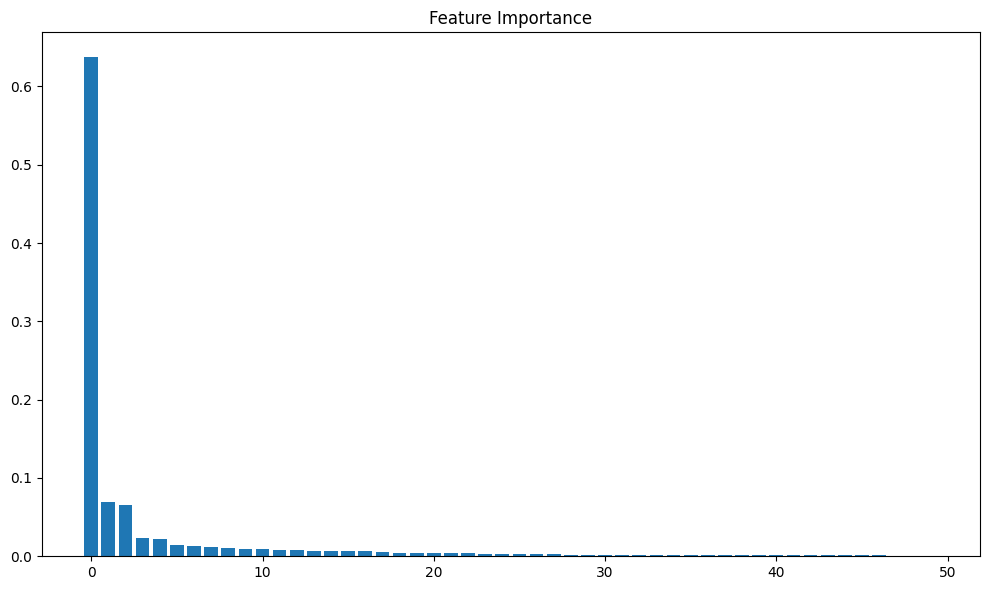

In [ ]:
importance = weather_models[23].feature_importances_
feature_names = features

sorted_idx = importance.argsort()[::-1]

print("Top 20 Most Important Features:")
for index in sorted_idx[:20]:
    print(f"{feature_names[index]}: {importance[index]:.4f}")

plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(50), importance[sorted_idx[:50]], align='center')
plt.tight_layout()
plt.show()

important_features = [features[id] for id in sorted_idx[:20]]


In [ ]:
target = ["pv_gen_+2h"]
test_size_hours = 31*24


final_models = train_model(dataset, important_features, target, test_size_hours)

Total Data Points: 26302
Capacity used for NRMSE: 2944.00 MW
Starting Time Series Cross-Validation...
Fold 1: RMSE = 41.56 MW, NRMSE = 1.41% (Train: 8760, Test: 744)
Fold 2: RMSE = 77.03 MW, NRMSE = 2.62% (Train: 9480, Test: 744)
Fold 3: RMSE = 97.90 MW, NRMSE = 3.33% (Train: 10200, Test: 744)
Fold 4: RMSE = 125.20 MW, NRMSE = 4.25% (Train: 10920, Test: 744)
Fold 5: RMSE = 93.77 MW, NRMSE = 3.19% (Train: 11640, Test: 744)
Fold 6: RMSE = 60.48 MW, NRMSE = 2.05% (Train: 12360, Test: 744)
Fold 7: RMSE = 75.00 MW, NRMSE = 2.55% (Train: 13080, Test: 744)
Fold 8: RMSE = 71.83 MW, NRMSE = 2.44% (Train: 13800, Test: 744)
Fold 9: RMSE = 63.16 MW, NRMSE = 2.15% (Train: 14520, Test: 744)
Fold 10: RMSE = 62.42 MW, NRMSE = 2.12% (Train: 15240, Test: 744)
Fold 11: RMSE = 55.79 MW, NRMSE = 1.90% (Train: 15960, Test: 744)
Fold 12: RMSE = 34.49 MW, NRMSE = 1.17% (Train: 16680, Test: 744)
Fold 13: RMSE = 40.88 MW, NRMSE = 1.39% (Train: 17400, Test: 744)
Fold 14: RMSE = 73.41 MW, NRMSE = 2.49% (Train: 18